In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import nmf, util

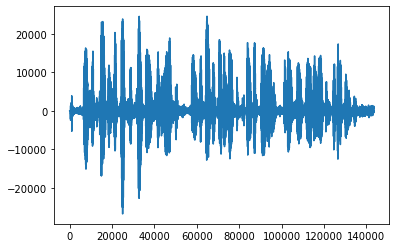

In [2]:
sampling_rate, x = wavfile.read('sources/record1source16k.wav')
wavfile_dtype = x.dtype
x = x.sum(axis=1)[:,None] # down-mix to single channel
_ = plt.plot(x)

<ipython-input-3-9433f515cdd3>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  X2 = (X*X.conj()).astype(np.double) # power spectrogram
<ipython-input-3-9433f515cdd3>:8: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X2), origin='lower', interpolation='none')


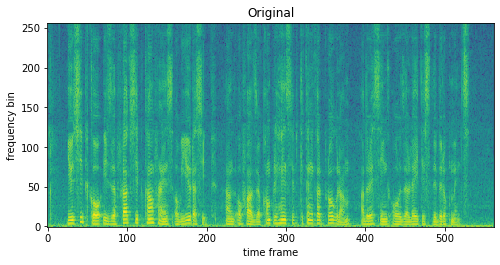

In [3]:
# STFT
fftSize = 512
frameShift = 256
X = util.stftTensor(x, fftSize, frameShift) # (nMic,nFreq,nTime)
X = X[0]  # size [1, nFreq, nTime] -> [nFreq, nTime]
X2 = (X*X.conj()).astype(np.double) # power spectrogram
plt.figure(figsize=(8,8))
plt.imshow(np.log(X2), origin='lower', interpolation='none')
plt.title('Original'), plt.xlabel('time frame'), plt.ylabel('frequency bin')
plt.savefig('original.png')

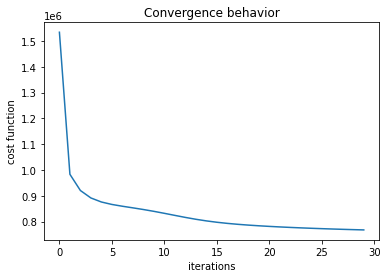

In [4]:
# NMF
model = nmf.NMF(X2, nBasis=10)
model.optimization(nLoop=30)
_ = plt.plot(model.losshist)
plt.title('Convergence behavior'), plt.xlabel('iterations'), plt.ylabel('cost function')
plt.savefig('converge.png')

<ipython-input-5-c42cfca14296>:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(model.V.T), aspect=5, interpolation='none')


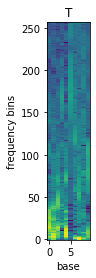

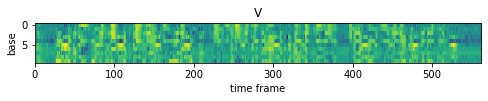

In [5]:
plt.figure(figsize=(3,4))
plt.imshow(np.log(model.T), aspect=0.2, origin='lower', interpolation='none')
plt.title('T'), plt.xlabel('base'), plt.ylabel('frequency bins')
plt.savefig('T.png')
plt.figure(figsize=(8,5))
plt.imshow(np.log(model.V.T), aspect=5, interpolation='none')
plt.title('V'), plt.xlabel('time frame'), plt.ylabel('base')
plt.savefig('V.png')

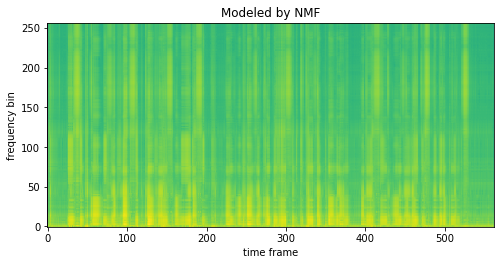

In [6]:
plt.figure(figsize=(8,4))
plt.imshow(np.log(model.Var), origin='lower', interpolation='none')
plt.title('Modeled by NMF'), plt.xlabel('time frame'), plt.ylabel('frequency bin')
plt.savefig('NMFmodel.png')

In [7]:
def reconstruct_sound(Var, X):
    amplitude = np.sqrt(Var)
    phase = X/(np.abs(X)+np.spacing(1))
    X1r = amplitude*phase
    xr = util.istftTensor(X1r[None,:,:], fftSize, frameShift)
    return xr

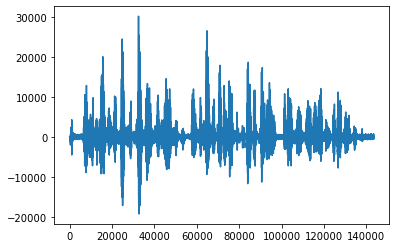

In [8]:
xr = reconstruct_sound(model.Var, X)
scale = 0.7
xr = (scale*xr).astype(wavfile_dtype)
plt.plot(xr)
wavfile.write('xr.wav', sampling_rate, xr)